In [1]:
from pyspark.sql.types import *
import numpy as np

def spark_curve_fit(
    f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, 
    bounds=(-np.inf, np.inf), method=None, jac=None, **kwargs
) -> StructType(
       [
           StructField(
               "info", 
               StructType(
                   [
                       StructField("message", StringType()),
                       StructField("good", BooleanType()),
                       StructField("runtime", FloatType()),
                   ]
               )
           ),
           StructField(
               "popt", 
               ArrayType(FloatType())
           ),
           StructField(
               "pcov", 
               ArrayType(ArrayType(FloatType()))
           )
       ]
       
):
    from scipy.optimize import curve_fit, OptimizeWarning
    from time import time

    t1 = time()
    
    ret = {
        "info" : {
            "message" : None,
            "runtime" : None,
            "good" : None,
        },
        "popt" : None,
        "pcov" : None,
    }
    
    try:
        popt, pcov = curve_fit(
            f, xdata, ydata, p0=p0, sigma=sigma, absolute_sigma=absolute_sigma, 
            check_finite=check_finite, bounds=bounds, method=method, jac=jac, **kwargs
        )
        popt = popt.astype(np.float64).tolist()
        pcov = pcov.astype(np.float64).tolist()
        
        ret["popt"] = popt
        ret["pcov"] = pcov
        
        ret['info']['message'] = "OK"
        ret['info']['good'] = True
    except (ValueError, RuntimeError, OptimizeWarning, TypeError) as e:
        ret['info']['message'] = str(e)
        ret['info']['good'] = False
        
    t2 = time()
    ret['info']['runtime'] = t2 - t1
    
    return ret

def spark_curve_fit_udf(f, kwargs_from_df=[], **udf_kwargs):
    import inspect
    from pyspark.sql.functions import udf

    sig = inspect.signature(spark_curve_fit)
    schema = sig.return_annotation
    
    if len(kwargs_from_df) == 0:
        _func = lambda *columns : spark_curve_fit(f, columns[0], columns[1], **udf_kwargs)
    else:
        def _with_kwargs(*columns):
            kwargs = { arg_name : col for arg_name, col in zip(kwargs_from_df, columns[2:]) }
            kwargs.update(udf_kwargs)
            return spark_curve_fit(f, columns[0], columns[1], **kwargs)
        _func = _with_kwargs
        
    return udf(
        _func, 
        schema
    )

In [2]:
from pyspark.sql import SparkSession
spark = ( 
    SparkSession
    .builder
    .config("spark.master", "local[*]")
    .config("spark.driver.memory", "120g")
    .config("spark.driver.maxResultSize", "0")
    .enableHiveSupport()
    .getOrCreate()
)

In [3]:
import socket
port = spark.sparkContext.uiWebUrl.split(":")[-1]
hostname = socket.gethostname()
print(f"https://{hostname}/jupyter/user/stevengs/proxy/{port}/jobs/")

https://epyc.astro.washington.edu/jupyter/user/stevengs/proxy/4047/jobs/


Define a model. A model is a function whose first argument is the independent variable (`x`) and whose following arguments are the parameters of the model. Keyword arguments are not supported right now.

In [4]:
def line(x, slope, intercept):
    return slope * x + intercept

def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

Test on small data

In [27]:
from pyspark.sql import Row
df = spark.createDataFrame(
    [
        Row(x=_x, y=_y, yerr=_yerr) 
        for _x, _y, _yerr in zip([[1, 2, 3, 10]], [[-1, 5, 6, 7]], [[0.1, 0.2, 0.05, 0.3]])
    ]
)

df.withColumn(
    "fit",
    spark_curve_fit_udf(
        # pass the model to be evaluated here
        quadratic,
        # pass the names of kwargs that are defined as rows of the dataframe
        # must be in the order of the columns passed to the UDF
        kwargs_from_df=["sigma"],
        # kwargs that are static for each row can be passed as normal
        maxfev=2000
    )(
        # pass the columns of the dataframe that act as the x and y variable
        df['x'], df['y'], 
        # pass columns that represent kwargs in the order of kwargs_from_df
        df['yerr']
    )
).collect()

[Row(x=[1, 2, 3, 10], y=[-1, 5, 6, 7], yerr=[0.1, 0.2, 0.05, 0.3], fit=Row(info=Row(message='OK', good=True, runtime=0.17469501495361328), popt=[-0.36694520711898804, 4.892867565155029, -5.305125713348389], pcov=[[0.006968347355723381, -0.06620512902736664, 0.11660031229257584], [-0.06620512902736664, 0.7427449822425842, -1.4177886247634888], [0.11660031229257584, -1.4177886247634888, 2.992992639541626]]))]

In [8]:
import axs
catalog = axs.AxsCatalog(spark)
wtf = catalog.load("stevengs_cut_wtf")

In [14]:
fit_df = wtf.withColumn(
    "fit",
    spark_curve_fit_udf(
        quadratic,
        kwargs_from_df=["sigma"],
        maxfev=2000
    )(
        wtf['mjd_r'], wtf['mag_r'], 
        wtf['magerr_r']
    )
).select(
    "ra",
    "dec",
    "zone",
    "mjd_r",
    "mag_r",
    "magerr_r",
    "fit"
).collect()

In [15]:
fit_df[0]['fit']

Row(info=Row(message='OK', good=True, runtime=0.30997252464294434), popt=[9.207771967112421e-08, -0.010790426284074783, 330.30084228515625], pcov=[[2.194744316773539e-15, -2.5672719505820396e-10, 7.507497230108129e-06], [-2.5672719505820396e-10, 3.003032543347217e-05, -0.8781800866127014], [7.507497230108129e-06, -0.8781800866127014, 25680.7265625]])

In [23]:
def plot_model(x, y, yerr, model, params):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # plot data
    plt.errorbar(x, y, yerr=yerr, fmt="o", label="data")
    
    # plot model
    min_x = np.min(x)
    max_x = np.max(x)
    _x = np.linspace(min_x, max_x, 10000)
    _y = model(_x, *params)    
    plt.plot(_x, _y, label="model")

    plt.legend()

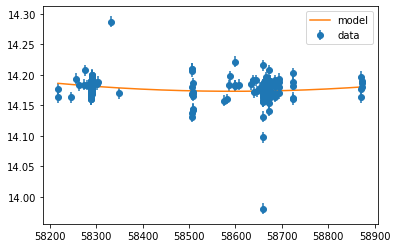

In [26]:
plot_model(
    fit_df[0]['mjd_r'], fit_df[0]['mag_r'], fit_df[0]['magerr_r'],
    quadratic, fit_df[0]['fit']['popt']
)

In [53]:
def my_model(
    x,
    # parameters
    a : FloatType(),
    b : FloatType(),
):
    return a * x + b

In [56]:
def _fit()

def make_fit_udf(model, model_schema=None):
    def _infer_schema(model):
        sig = inspect.signature(model)
        params = sig.parameters
        param_names = list(params.keys())
        if len(param_names) > 1:
            param_names = param_names[1:]
        else:
            raise RuntimeError("model passed to fit_udf must have at least one fit parameter")

        schema = []
        
        param_schema = []
        for p in param_names:
            if params[p].annotation == inspect._empty:
                raise RuntimeError(f"Parameter {p} in {model} has an empty annotation; cannot infer schema automatically")
            param_schema.append(StructField(p, params[p].annotation))
        schema.append(StructField("parameters", StructType(param_schema)))
        
        param_init_schema = []
        for p in param_names:
            param_init_schema.append(StructField(f"{p}_init", params[p].annotation))
        schema.append(StructField("initial_parameters", StructType(param_init_schema)))
        
        return schema
    
    _fit_schema_defaults = [
        StructField("good_fit", BooleanType(), False),
        StructField("message", StringType(), False),
        StructField("chi_square", FloatType(), False),
        StructField("chi_square_reduced", FloatType(), False),
        StructField("runtime", FloatType(), False),
    ]
    
    if model_schema is None:
        # infer schema automatically
        model_schema = _infer_schema(model)
    
    print("inferred schema for model:", model_schema)
    
    schema = StructType(
        sum([_fit_schema_defaults, model_schema], [])
    )

    return udf(model, schema)

def fit_rows(df, model, initial_parameters, x_column, initial_parameters_columns=[], model_schema=None):
    if len(initial_parameters_columns > 0):
        
    columns_to_use = sum([[x_column], initial_parameters_columns], [])
    
    _udf = fit_udf(model, model_schema=model_schema)
    fit_df = df.select(
        *columns_to_use,
        _udf(x_column).alias(
            "fit"
        )
    )
    
    return fit_df

IndentationError: expected an indented block (<ipython-input-56-5efeef51005c>, line 50)

In [55]:
fit_udf(my_model)

inferred schema for model: [StructField(parameters,StructType(List(StructField(a,FloatType,true),StructField(b,FloatType,true))),true), StructField(initial_parameters,StructType(List(StructField(a_init,FloatType,true),StructField(b_init,FloatType,true))),true)]


<function __main__.my_model(x, a: FloatType, b: FloatType)>

In [52]:
import inspect
inspect.signature(my_model).parameters

mappingproxy({'x': <Parameter "x">,
              'a': <Parameter "a: FloatType">,
              'b': <Parameter "b: FloatType">})

In [ ]:
def _fit_udf_init_callable(model, init, model_schema=None, init_schema=None):
    

In [20]:
def fit_udf(model, initial_parameters, with_errors=True, schema_fields=None, infer=True):
    from pyspark.sql.functions import udf
    from pyspark.sql.types import FloatType, StringType, BooleanType
    from functools import partial
    import inspect
    
    _fit_schema_defaults = [
        StructField("good_fit", BooleanType(), False),
        StructField("message", StringType(), False),
        StructField("chi_square", FloatType(), False),
        StructField("chi_square_reduced", FloatType(), False),
        StructField("runtime", FloatType(), False),
    ]
    
    def infer_schema(model):
        sig = inspect.signature(model)
        params = sig.parameters
        param_names = list(params.keys())
        if len(param_names) > 1:
            param_names = param_names[1:]
        else:
            raise RuntimeError("model passed to fit_udf must have at least one parameter")

        schema = []
        
        param_schema = []
        for p in param_names:
            if params[p].annotation == inspect._empty:
                raise RuntimeError(f"Parameter {p} in {model} has an empty annotation; cannot infer schema automatically")
            param_schema.append(StructField(p, params[p].annotation))
        schema.append(StructField("params", StructType(param_schema)))
        
        param_init_schema = []
        for p in param_names:
            param_init_schema.append(StructField(f"{p}_init", params[p].annotation))
        schema.append(StructField("params_init", StructType(param_init_schema)))
        
        return schema
    
    if infer:
        if schema_fields is None:
            if model is None:
                raise RuntimeError("must pass model to fit_udf to infer schema")
            else:
                schema_fields = infer_schema(model)
    else:
        if schema_fields is None:
            raise RuntimeError("must pass schema_fields to fit_udf if not inferring schema from model")
    
    schema = StructType(
        sum([_fit_schema_defaults, schema_fields], [])
    )
    
    print(schema)
    if with_errors:
        return udf(lambda x, y, yerr, *extra_cols: fit(x, y, yerr, model, initial_parameters, *extra_cols, max_iter=2000), schema)
    else:
        return udf(lambda x, y, *extra_cols : fit(x, y, None, model, initial_parameters, *extra_cols, max_iter=2000), schema)


In [21]:
fit_udf(my_model, [1, 2, 3])

StructType(List(StructField(good_fit,BooleanType,false),StructField(message,StringType,false),StructField(chi_square,FloatType,false),StructField(chi_square_reduced,FloatType,false),StructField(runtime,FloatType,false),StructField(params,StructType(List(StructField(y,ArrayType(FloatType,true),true),StructField(yerr,ArrayType(FloatType,true),true),StructField(params,ArrayType(FloatType,true),true))),true),StructField(params_init,StructType(List(StructField(y_init,ArrayType(FloatType,true),true),StructField(yerr_init,ArrayType(FloatType,true),true),StructField(params_init,ArrayType(FloatType,true),true))),true)))


<function __main__.fit_udf.<locals>.<lambda>(x, y, yerr, *extra_cols)>

In [18]:
IntegerType()

IntegerType

In [8]:
sig = inspect.signature(my_model)
params = sig.parameters

In [12]:
params['t'].annotation == inspect._empty

True